In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import scipy
import seaborn as sns
import sklearn
import textdistance
import torch
import warnings

from pprint import pprint
from tabulate import tabulate
from tqdm.auto import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForMaskedLM, logging as transformers_logging

In [2]:
warnings.filterwarnings('ignore')
transformers_logging.set_verbosity_error()

### Load RoBERTa model trained on Russian rental ads

In [3]:
tokenizer = AutoTokenizer.from_pretrained("rafagudinov/ru_rent_estate_ads")
model = AutoModelForMaskedLM.from_pretrained("rafagudinov/ru_rent_estate_ads")

fill_mask_ru = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer,
    device=(0 if torch.cuda.is_available() else -1)
)

### Load RoBERTa model trained on English rental ads

In [4]:
tokenizer = AutoTokenizer.from_pretrained("rafagudinov/en_rent_estate_ads")
model = AutoModelForMaskedLM.from_pretrained("rafagudinov/en_rent_estate_ads")

fill_mask_en = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

# Setting hypothesis

According to the distributional hypothesis, similar words tend to be in the same context. So intuitively, we can assume, reverse hypothesis, that **similar contexts tend to have the same words**.

If this hypothesis is correct, we can set in advance a reference context where the desired value may be located, and then find similar contexts in the analyzed text. It will give us the most probable positions in the text, where the sought-for feature value seats.

Let's state we need to extract the number of rooms from a fuzzy Russian text. First, let's set up a reference context where the number of rooms is likely to be.

### Setup reference context for Russian example

In [5]:
context_text = """
Сдается <mask> квартира
"""
ref_context_tokens_ru = fill_mask_ru(context_text, top_k=100)

### Helper function to parse text 

In [6]:
def parse_text(text, fill_mask_func, ref_context_tokens, dist_func):
    result = {"tokens": [], "dists": []}
    
    tokens = re.split(r"(\W)", text)
    
    for i in range(len(tokens)):
        if not tokens[i].isalnum():
            continue

        masked_text = ""

        for j in range(len(tokens)):
            if i == j:
                masked_text += "<mask>"
            else:
                masked_text += tokens[j]

        pos_context_tokens = fill_mask_func(masked_text, top_k=100)
        
        dist = round(abs(dist_func(ref_context_tokens, pos_context_tokens)), 2)
        
        result["tokens"].append(tokens[i])
        result["dists"].append(dist)
    
    result["norm_dists"] = [round(d, 2) for d in sklearn.preprocessing.normalize([result["dists"]])[0]]
    
    for token, dist, norm_dist in zip(result["tokens"], result["dists"], result["norm_dists"]):
        print(f"{token} - {dist} ({norm_dist})")
    
    sns.set_context("paper", font_scale=1.3)
    
    plt.figure(figsize=(15, 3))
    sns.lineplot(x=result["tokens"], y=result["norm_dists"]).set_title("Distances to ref. context")

In [7]:
def jaro_dist_func(ref_context_tokens, pos_context_tokens):
    dist = 1 - textdistance.jaro(
        [t["token"] for t in ref_context_tokens],
        [t["token"] for t in pos_context_tokens]
    )
    
    return dist

### Jaro-Winkler distances for Russian text

Now let’s suppose we need to parse the following Russian text: "*В аренду предлагается 1к квартирка, в которой есть 2к холодильник*"

Let’s calculate differences between the reference context and contexts in each text position. For this purpose, we use the Jaro-Winkler distance function.

В - 1.0 (0.42)
аренду - 0.76 (0.32)
предлагается - 0.69 (0.29)
1к - 0.47 (0.2)
квартирка - 0.72 (0.31)
в - 0.81 (0.34)
которой - 0.66 (0.28)
есть - 0.82 (0.35)
2к - 0.74 (0.31)
холодильник - 0.66 (0.28)


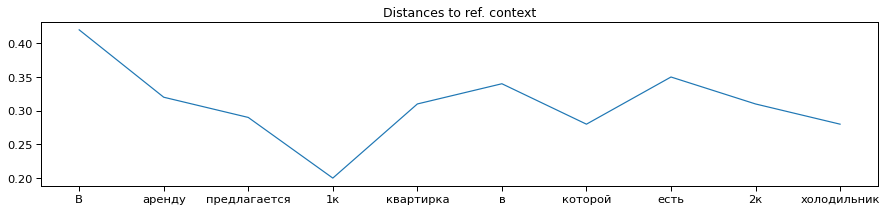

In [8]:
text = "В аренду предлагается 1к квартирка, в которой есть 2к холодильник"
parse_text(text, fill_mask_ru, ref_context_tokens_ru, jaro_dist_func)

Taking into account the obtained distance values, it is obvious that the desired value is most likely in the position where the "1к" token is located. The position is correct, even though the analyzed text does not contain the "Сдается" word from the reference context, and "квартира" has slightly changed. The normalized distance difference between rival wrong “2к” and correct “1к" positions is about 0.11.

### Setup reference context for English example

Now let's complicate the task, let's assume we need to extract a price value from very fuzzy text of a rental ad in English. First of all, we need to set up a reference context

In [9]:
context_text = """
Price <mask>
"""
ref_context_tokens_en = fill_mask_en(context_text, top_k=100)

### Jaro-Winkler distances for English text

Let’s suppose we need to analyze (extract price) the following English text: "*Nice townhouse, 1000 sq ft 3000 monthly*".

By analogy with the Russian example, let’s calculate the differences between reference and positions contexts

Nice - 0.72 (0.39)
townhouse - 0.74 (0.4)
1000 - 0.66 (0.36)
sq - 0.77 (0.42)
ft - 0.65 (0.35)
3000 - 0.61 (0.33)
monthly - 0.71 (0.39)


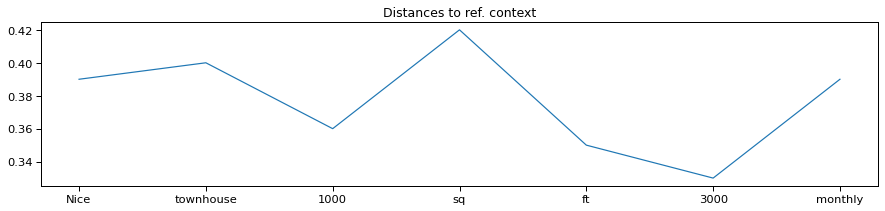

In [10]:
text = "Nice townhouse, 1000 sq ft 3000 monthly"
parse_text(text, fill_mask_en, ref_context_tokens_en, jaro_dist_func)

The minimum distance is in the correct position, where the “3000” token is located. The normalized distance difference between rival wrong “1000” and correct “3000” is about 0.03.

### Custom distance function

The Jaro-Winkler distance uses token position, but it does not take into account probabilities. This leads to information loss. Let's use the following custom distance function that doesn't have this drawback.

In [11]:
def custom_dist_func(ref_context_tokens, pos_context_tokens):    
    ref_context_tokens = {t["token"]:t["score"] for t in ref_context_tokens}
    pos_context_tokens = {t["token"]:t["score"] for t in pos_context_tokens}
    
    dist = 0

    for item in ref_context_tokens:
        if item not in pos_context_tokens:
            dist += ref_context_tokens[item]
        else:
            dist += ref_context_tokens[item] - pos_context_tokens[item]

    return dist

### Custom distance function for Russian text

В - 0.98 (0.38)
аренду - 0.98 (0.38)
предлагается - 0.95 (0.37)
1к - 0.03 (0.01)
квартирка - 0.12 (0.05)
в - 0.45 (0.17)
которой - 0.98 (0.38)
есть - 0.98 (0.38)
2к - 0.92 (0.36)
холодильник - 0.93 (0.36)


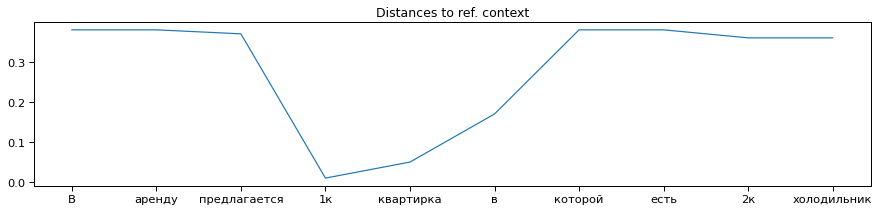

In [12]:
text = "В аренду предлагается 1к квартирка, в которой есть 2к холодильник"
parse_text(text, fill_mask_ru, ref_context_tokens_ru, custom_dist_func)

The normalized distance difference between rival wrong “2к” and correct “1к" positions is about 0.35. We are interested in distinguishing them as much as possible. So it is a much better result comparing with Jaro- Winkler’s 0.11.

### Custom distance function for English text

Nice - 0.62 (0.46)
townhouse - 0.18 (0.13)
1000 - 0.58 (0.43)
sq - 0.67 (0.49)
ft - 0.6 (0.44)
3000 - 0.06 (0.04)
monthly - 0.52 (0.38)


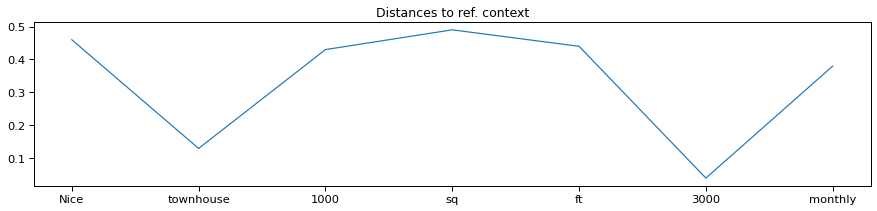

In [13]:
text = """
Nice townhouse, 1000 sq ft 3000 monthly
"""
parse_text(text, fill_mask_en, ref_context_tokens_en, custom_dist_func)

The normalized distance difference between rival values is about 0.3. So it is a 10 times better result comparing with Jaro-Winkler’s 0.03.

## Hypothesis testing

If we claim that distances between the reference context and correct positions differ from the distances for the wrong positions, we should rely on statistical hypothesis tests. Let’s analyze the distributions for both distance sets using a dataset having 20K+ documents.

### Calculate distances to the reference context for right and wrong positions

In [14]:
with open("./datasets/ru_rooms_num.json", "r") as fh:
    docs = json.load(fh)

len(docs)

23055

In [15]:
pprint(docs[:5])

[{'right_pos': 2,
  'right_token': 'однокомн',
  'text': 'PHONE Сдам однокомн квартиру желательно на длительный срок в центре '
          'города. В квартире есть все для комфортного проживания. Вся мебель '
          'и техника есть в квартире. Возможно проживание с детьми и / или с '
          'животными. Рассмотрю всех платежеспособных.звоните PHONE , фото '
          'отправлю в лс.'},
 {'right_pos': 1,
  'right_token': 'однокомнатную',
  'text': 'Сдаю однокомнатную квартиру на длительный срок. Пирогова 1к3 Мебель '
          'и техника все остаются, в рабочем состоянии. 6.500 руб/месяц, '
          'залога нет, свет+вода оплачиваются отдельно по счетчикам. '
          'Рассматриваю всех желающих. Есть WhаtsАрр. PHONE'},
 {'right_pos': 15,
  'right_token': '1комн',
  'text': 'Москва, район Восточное Измайлово, 16-я Парковая улица, 19к1. '
          'Ближайшее метро Первомайская 6мин.трансп. Сдам 1комн квартиру по '
          'отличной цене. Транспорт до метро ходит по расписанию. Р

In [16]:
right_pos_dists = []
wrong_pos_dists = []

for doc in tqdm(docs):
    tokens = re.split(r"\W+", doc["text"])

    right_pos = doc["right_pos"]
    wrong_pos = None

    while True:
        wrong_pos = random.randrange(len(tokens))

        if wrong_pos != right_pos and tokens[wrong_pos].isalnum():
            break

    right_pos_tokens = fill_mask_ru(
        "".join([tokens[i] if i != right_pos else "<mask>" for i in range(len(tokens))]),
        top_k=100
    )
    
    right_pos_dist = custom_dist_func(ref_context_tokens_ru, right_pos_tokens)    
        
    wrong_pos_tokens = fill_mask_ru(
        "".join([tokens[i] if i != wrong_pos else "<mask>" for i in range(len(tokens))]),
        top_k=100
    )

    wrong_pos_dist = custom_dist_func(ref_context_tokens_ru, wrong_pos_tokens)
    
    right_pos_dists.append(right_pos_dist)
    wrong_pos_dists.append(wrong_pos_dist)

  0%|          | 0/23055 [00:00<?, ?it/s]

### Distribution of distances between the reference context and correct positions

<AxesSubplot:>

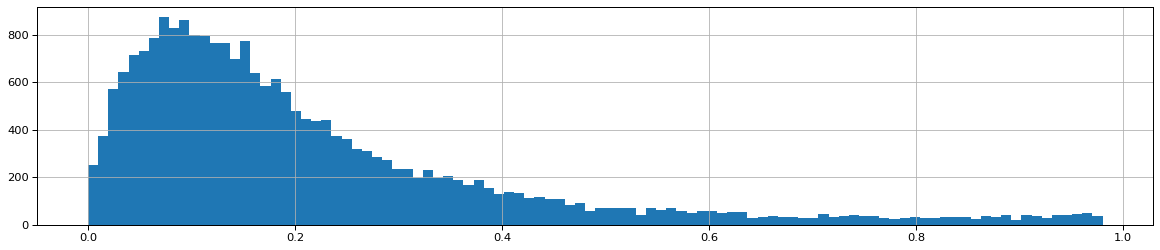

In [17]:
plt.figure(figsize=(20, 4))
pd.Series(right_pos_dists).hist(bins=100)

### Distribution of distances between the reference context and wrong positions

<AxesSubplot:>

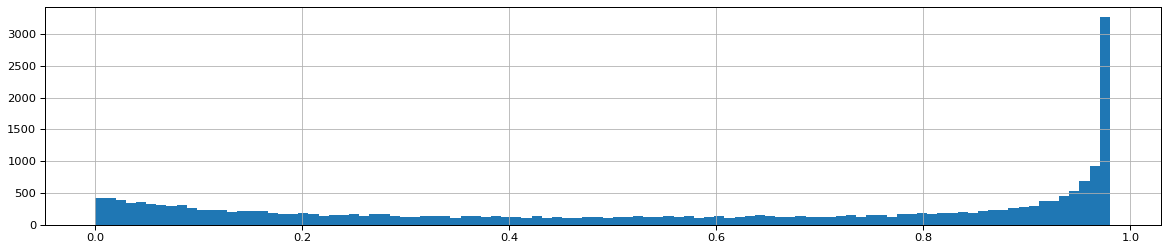

In [18]:
plt.figure(figsize=(20, 4))
pd.Series(wrong_pos_dists).hist(bins=100)

The distribution of distances on the above figures shows that they are probably not normally distributed, given their high asymmetry (skewness).

### Shapiro-Wilk tests for normality

In [19]:
# p-value may not be accurate for big N, so 1000 limit here
scipy.stats.shapiro(right_pos_dists[:1000])

ShapiroResult(statistic=0.9075760841369629, pvalue=3.836018378506276e-24)

In [20]:
scipy.stats.shapiro(wrong_pos_dists[:1000])

ShapiroResult(statistic=0.888763427734375, pvalue=3.2588774604029126e-26)

p-value considerably less than the 0.05 threshold for both sets, which confirms that the distributions are not normal. Therefore, since we need to compare the means of two samples, we should use the Mann-Whitney U test

### Mann-Whitney U test to confirm the similar contexts hypothesis

*There are two possible outcomes: if the result confirms the hypothesis, then you’ve made a measurement. If the result is contrary to the hypothesis, then you’ve made a discovery (Enrico Fermi)*

To prove the concept, we should confirm that distances in right positions are less than in wrong ones. So we need to reject the opposite meaning. Let us set the null hypothesis that distances in wrong positions are equal or less than in right ones.

$H_0: \mu_{wrong} \leq \mu_{right}$ (distances in wrong positions are equal or less than in right ones)

$H_1: \mu_{wrong} > \mu_{right}$ (distances in wrong positions are more than in right ones)

In [21]:
scipy.stats.mannwhitneyu(right_pos_dists[:1000], wrong_pos_dists[:1000], alternative='less')

MannwhitneyuResult(statistic=281863.0, pvalue=2.5519834325211202e-64)

p-value considerably less than the 0.05 threshold. So we reject the null hypothesis in favor of the alternative one. We proved a statistically significant difference between the distances for right and wrong positions, and **for the right positions, the distances are incredibly smaller**.